In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy as sp
from tensorflow.keras.models import Model
from matplotlib import gridspec
import matplotlib as mpl
import os

# Configuration
IM_SIZE = 224
NUM_CLASSES = 2
CLASS_NAMES = ['no wildfire', 'wildfire']

def load_model_and_weights(model_path):
    """Load the pre-trained model"""
    model = tf.keras.models.load_model(model_path)
    return model

def prepare_cam_model(model):
    """Create CAM model from the base model"""
    cam_model = Model(inputs=model.input,
                     outputs=(model.layers[-3].output, model.layers[-1].output))
    gap_weights = model.layers[-1].get_weights()[0]
    return cam_model, gap_weights

def preprocess_image(image_path):
    """Load and preprocess an image"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (IM_SIZE, IM_SIZE))
    img_normalized = img_resized / 255.0
    return np.expand_dims(img_normalized, axis=0), img  # Return both processed and original

def create_heatmap(cam_output, img, alpha=0.5):
    """Create a properly scaled heatmap overlay"""
    # Normalize CAM output to 0-1
    cam_output = np.maximum(cam_output, 0)
    cam_output = cam_output / np.max(cam_output) if np.max(cam_output) > 0 else cam_output
    
    # Resize CAM to match image dimensions
    heatmap = cv2.resize(cam_output, (img.shape[1], img.shape[0]))
    
    # Apply colormap - use cv2's colormap for consistency
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Blend original image with heatmap
    superimposed = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    
    return superimposed, heatmap

def get_real_tag_from_path(image_path):
    """Extract the real tag (wildfire or nowildfire) from the image path"""
    if "wildfire" in image_path.lower():
        if "nowildfire" in image_path.lower():
            return "no wildfire"
        else:
            return "wildfire"
    return "unknown"

def show_cam(image_tensor, original_img, features, predictions, gap_weights, class_idx=1, image_path=None):
    """Generate and display an enhanced, beautiful Class Activation Map visualization"""
    # Set the style for a modern, clean look
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Set custom font properties for a more polished look
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    
    # Get the last convolutional layer features
    features_for_img = features[0]
    
    # Get the class weights for the specified class
    class_activation_weights = gap_weights[:, class_idx]
    
    # Create the CAM by doing a weighted sum of activation maps
    cam_output = np.dot(features_for_img, class_activation_weights)
    
    # Create heatmap and overlay
    superimposed_img, heatmap = create_heatmap(cam_output, original_img, alpha=0.6)  # Slightly increased alpha for better visibility
    
    # Create custom color map with improved aesthetics
    # Using 'inferno' colormap which has better perceptual properties than jet
    fire_colors = plt.cm.get_cmap('inferno')
    fire_colormap = LinearSegmentedColormap.from_list('inferno', fire_colors(np.linspace(0, 1, 256)))
    
    # Create a figure with custom layout
    fig = plt.figure(figsize=(16, 9), dpi=100, facecolor='#f8f8f8')
    
    # Use GridSpec for more control over layout
    gs = gridspec.GridSpec(2, 6, height_ratios=[4, 1])
    
    # Add a subtle background gradient to the figure
    fig.patch.set_alpha(0.8)
    
    # Original image with enhanced border
    ax1 = plt.subplot(gs[0, 0:2])
    ax1.imshow(original_img)
    ax1.set_title('Original Image', fontweight='bold', pad=15)
    ax1.set_xticks([])
    ax1.set_yticks([])
    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_color('#333333')
        spine.set_linewidth(2)
    
    # Heatmap with custom colormap
    ax2 = plt.subplot(gs[0, 2:4])
    heatmap_plot = ax2.imshow(heatmap, cmap=fire_colormap)
    ax2.set_title('Activation Heatmap', fontweight='bold', pad=15)
    ax2.set_xticks([])
    ax2.set_yticks([])
    for spine in ax2.spines.values():
        spine.set_visible(True)
        spine.set_color('#333333')
        spine.set_linewidth(2)
    
    # Overlay visualization
    ax3 = plt.subplot(gs[0, 4:6])
    ax3.imshow(superimposed_img)
    ax3.set_title('Overlay Visualization', fontweight='bold', pad=15)
    ax3.set_xticks([])
    ax3.set_yticks([])
    for spine in ax3.spines.values():
        spine.set_visible(True)
        spine.set_color('#333333')
        spine.set_linewidth(2)
    
    # Add colorbar with better styling
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=fire_colormap), cax=cbar_ax)
    cbar.set_label('Activation Intensity', fontweight='bold', labelpad=15)
    cbar.outline.set_linewidth(1)
    cbar.outline.set_edgecolor('#333333')
    
    # Prediction visualization with beautiful gauge charts
    # Create a horizontal bar chart for the predictions
    ax4 = plt.subplot(gs[1, 1:5])
    
    # Bar chart for prediction probabilities
    classes = CLASS_NAMES
    probabilities = predictions[0]
    
    # Define colors based on confidence (red for wildfire, blue for no wildfire)
    colors = ['#3498db', '#e74c3c']  # Blue for nowildfire, Red for wildfire
    
    # Create horizontal bars with rounded corners
    bars = ax4.barh(classes, probabilities, color=colors, height=0.5, alpha=0.8)
    
    # Add percentage labels inside the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x_pos = width / 2 if width > 0.25 else width + 0.03
        label_alignment = 'center' if width > 0.25 else 'left'
        color = 'white' if width > 0.25 else 'black'
        ax4.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                 f'{probabilities[i]*100:.1f}%', 
                 va='center', ha=label_alignment, color=color,
                 fontweight='bold', fontsize=12)
    
    # Add a vertical line at 0.5 for reference
    ax4.axvline(x=0.5, color='#7f8c8d', linestyle='--', alpha=0.5)
    
    # Add title to the prediction chart
    ax4.set_title('Classification Probabilities', fontweight='bold', pad=15)
    
    # Set x-axis limits and labels
    ax4.set_xlim(0, 1.0)
    ax4.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax4.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    # Adjust spines for cleaner look
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_linewidth(1.5)
    ax4.spines['bottom'].set_linewidth(1.5)
    
    # Add a decision indicator
    predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100
    decision_text = f"Prediction: {predicted_class.upper()} ({confidence:.1f}% confidence)"
    
    # Get the real tag from the image path
    real_tag = get_real_tag_from_path(image_path) if image_path else "unknown"
    
    # Add a banner at the top with the decision
    banner_color = '#e74c3c' if predicted_class == 'wildfire' else '#3498db'
    banner_width = 0.65  # Adjust width to make room for the real tag
    banner_ax = fig.add_axes([0.05, 0.92, banner_width, 0.06])
    banner_ax.set_facecolor(banner_color)
    banner_ax.text(0.5, 0.5, decision_text, 
                  ha='center', va='center', color='white', 
                  fontsize=16, fontweight='bold')
    banner_ax.set_xticks([])
    banner_ax.set_yticks([])
    
    # Add real tag banner next to the prediction banner
    real_tag_color = '#e74c3c' if real_tag == 'wildfire' else '#3498db'
    real_tag_ax = fig.add_axes([0.05 + banner_width + 0.02, 0.92, 0.23, 0.06])
    real_tag_ax.set_facecolor(real_tag_color)
    real_tag_ax.text(0.5, 0.5, f"Actual: {real_tag.upper()}", 
                    ha='center', va='center', color='white', 
                    fontsize=16, fontweight='bold')
    real_tag_ax.set_xticks([])
    real_tag_ax.set_yticks([])
    
    # Add image path as footer (using the original image_path parameter)
    footer_ax = fig.add_axes([0.05, 0.01, 0.9, 0.03])
    footer_ax.axis('off')
    if image_path:
        footer_ax.text(0.5, 0.5, f"Image: {os.path.basename(image_path)}", 
                      ha='center', va='center', color='#555555', fontsize=10)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.05, 0.9, 0.9])
    
    return fig

def predict_and_visualize(image_path, output_path=None, model_path='../saved_models/custom_best_model.h5'):
    """Main function to load model and visualize predictions with improved visualization"""
    # Load models
    model = load_model_and_weights(model_path)
    cam_model, gap_weights = prepare_cam_model(model)
    
    # Process image - get both processed tensor and original image
    image_tensor, original_img = preprocess_image(image_path)
    
    # Get predictions and features
    features, predictions = cam_model.predict(image_tensor)
    
    # Show results
    print(f"Predictions for {image_path}:")
    print(f"No Wildfire: {predictions[0][0]*100:.2f}%")
    print(f"Wildfire: {predictions[0][1]*100:.2f}%")
    
    # Generate visualization
    fig = show_cam(image_tensor, original_img, features, predictions, gap_weights, image_path=image_path)
    
    # Save the visualization if requested
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {output_path}")
    
    plt.show()

2025-05-09 08:23:08.703523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Predictions for ./../data/test/wildfire/-77.53735,51.2545.jpg:
No Wildfire: 0.86%
Wildfire: 99.14%


/tmp/ipykernel_205309/4146192777.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fire_colors = plt.cm.get_cmap('inferno')
/tmp/ipykernel_205309/4146192777.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.9])


Visualization saved to ./../data/test/wildfire/-77.53735,51.2545_cam_viz.png


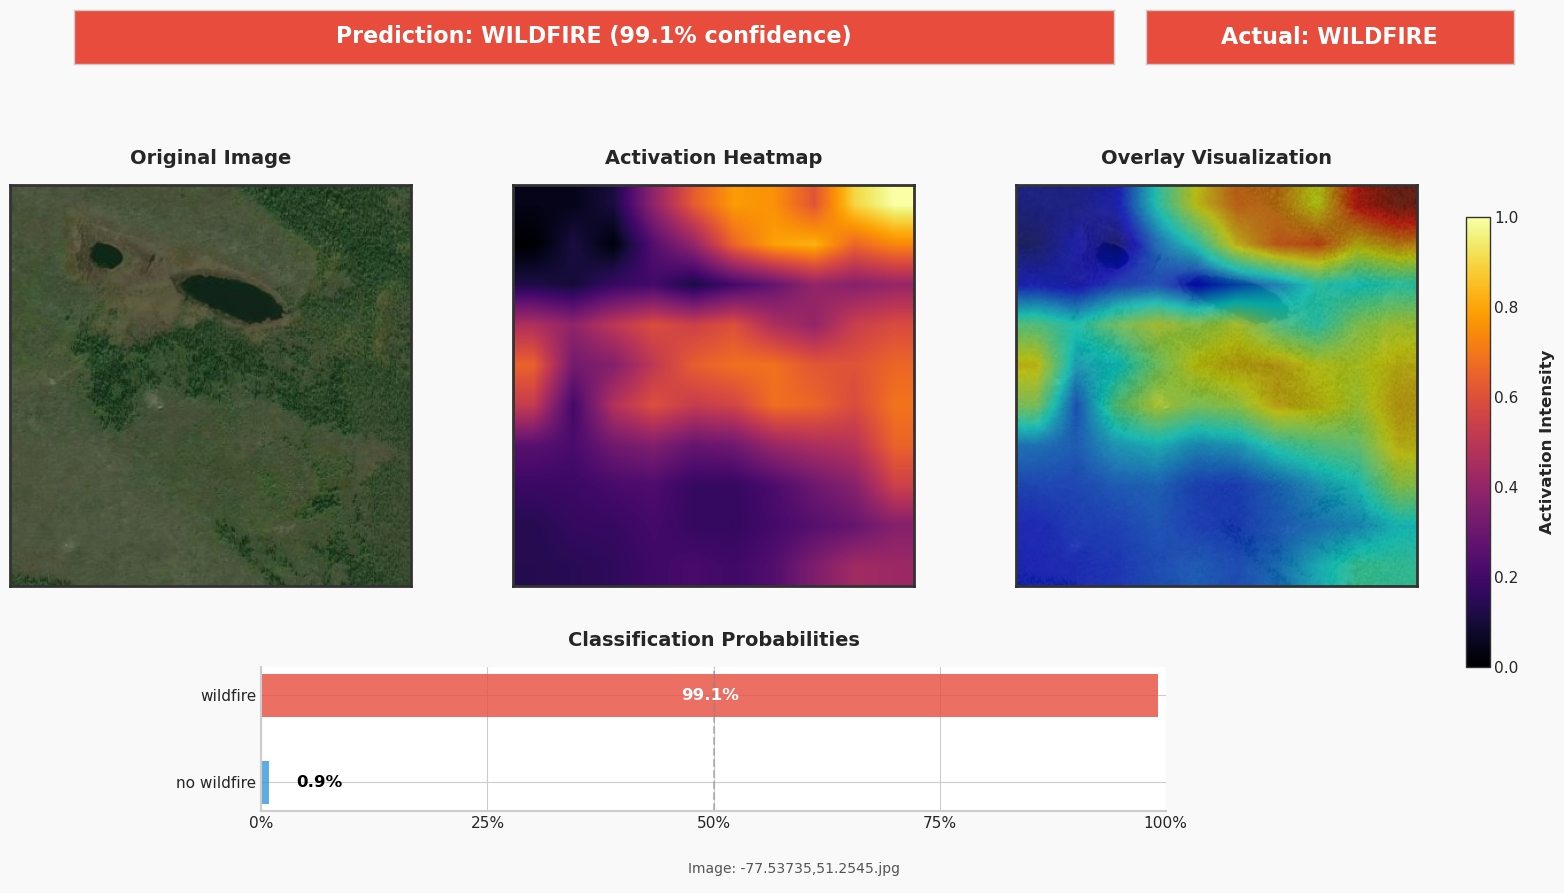

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Predictions for ./../data/test/nowildfire/-123.196703,49.113488.jpg:
No Wildfire: 97.23%
Wildfire: 2.77%


/tmp/ipykernel_205309/4146192777.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fire_colors = plt.cm.get_cmap('inferno')
/tmp/ipykernel_205309/4146192777.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.9])


Visualization saved to ./../data/test/nowildfire/-123.196703,49.113488_cam_viz.png


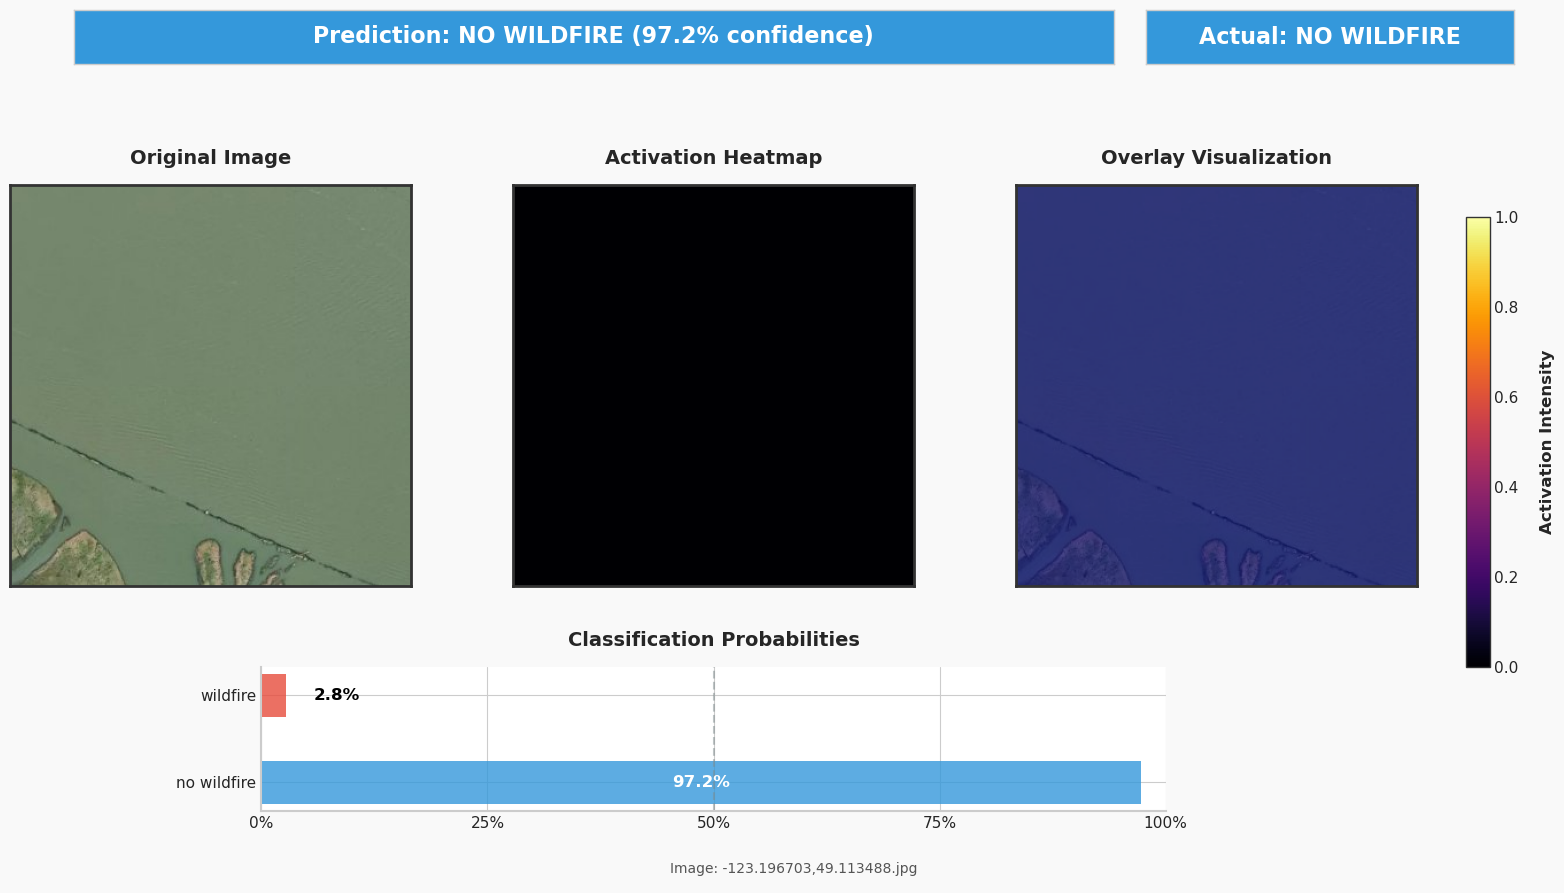

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Predictions for ./../data/test/wildfire/-70.05845,46.631.jpg:
No Wildfire: 2.34%
Wildfire: 97.66%


/tmp/ipykernel_205309/4146192777.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fire_colors = plt.cm.get_cmap('inferno')
/tmp/ipykernel_205309/4146192777.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.9])


Visualization saved to ./../data/test/wildfire/-70.05845,46.631_cam_viz.png


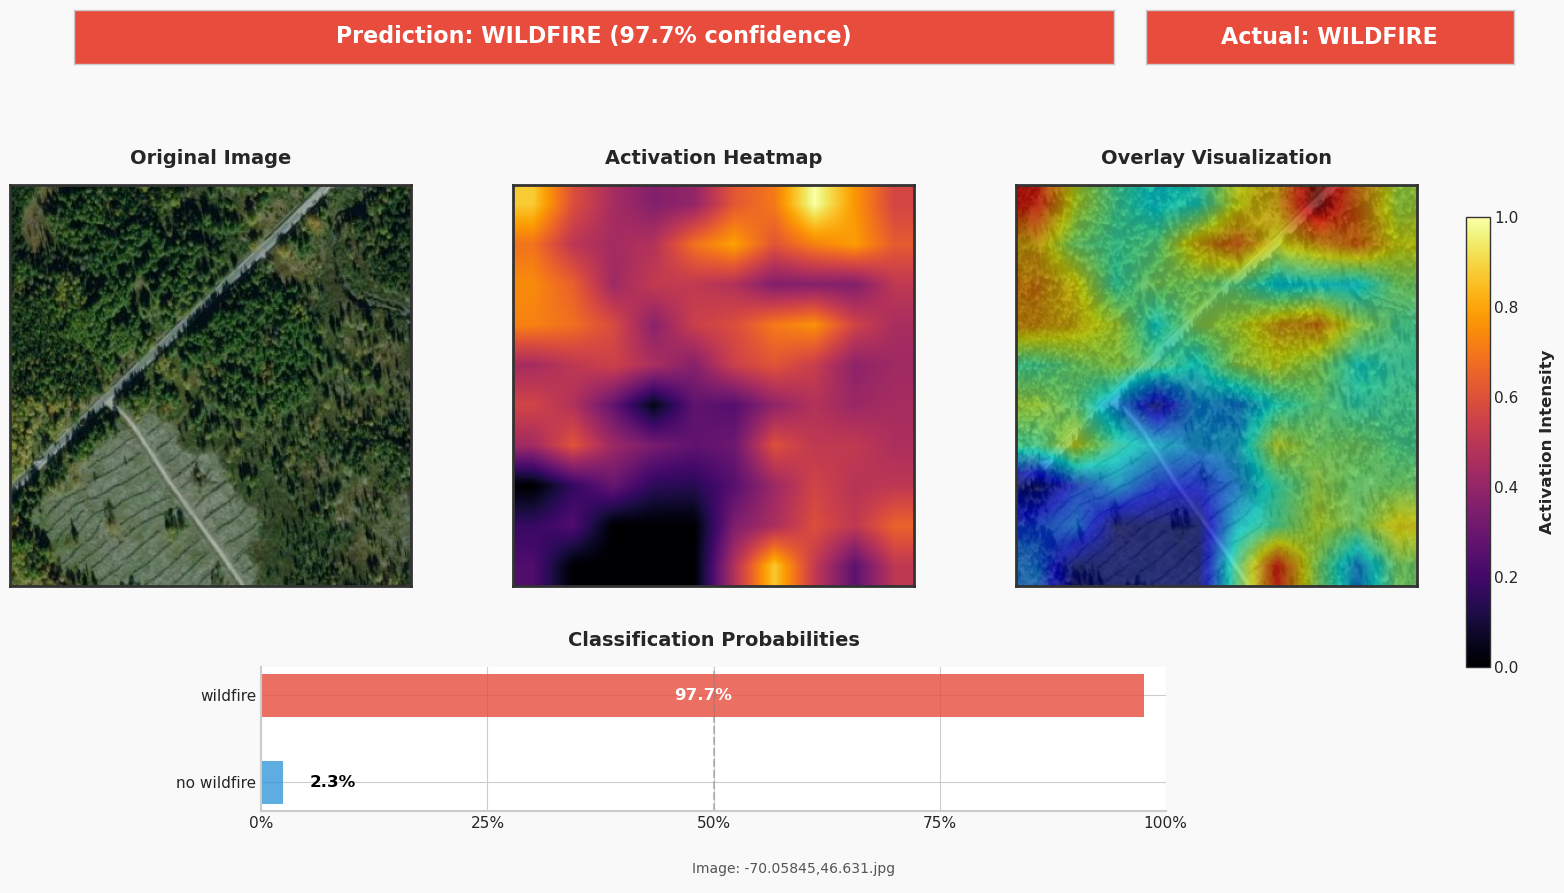

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predictions for ./../data/test/nowildfire/-79.296438,43.785744.jpg:
No Wildfire: 98.91%
Wildfire: 1.09%


/tmp/ipykernel_205309/4146192777.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fire_colors = plt.cm.get_cmap('inferno')
/tmp/ipykernel_205309/4146192777.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.9])


Visualization saved to ./../data/test/nowildfire/-79.296438,43.785744_cam_viz.png


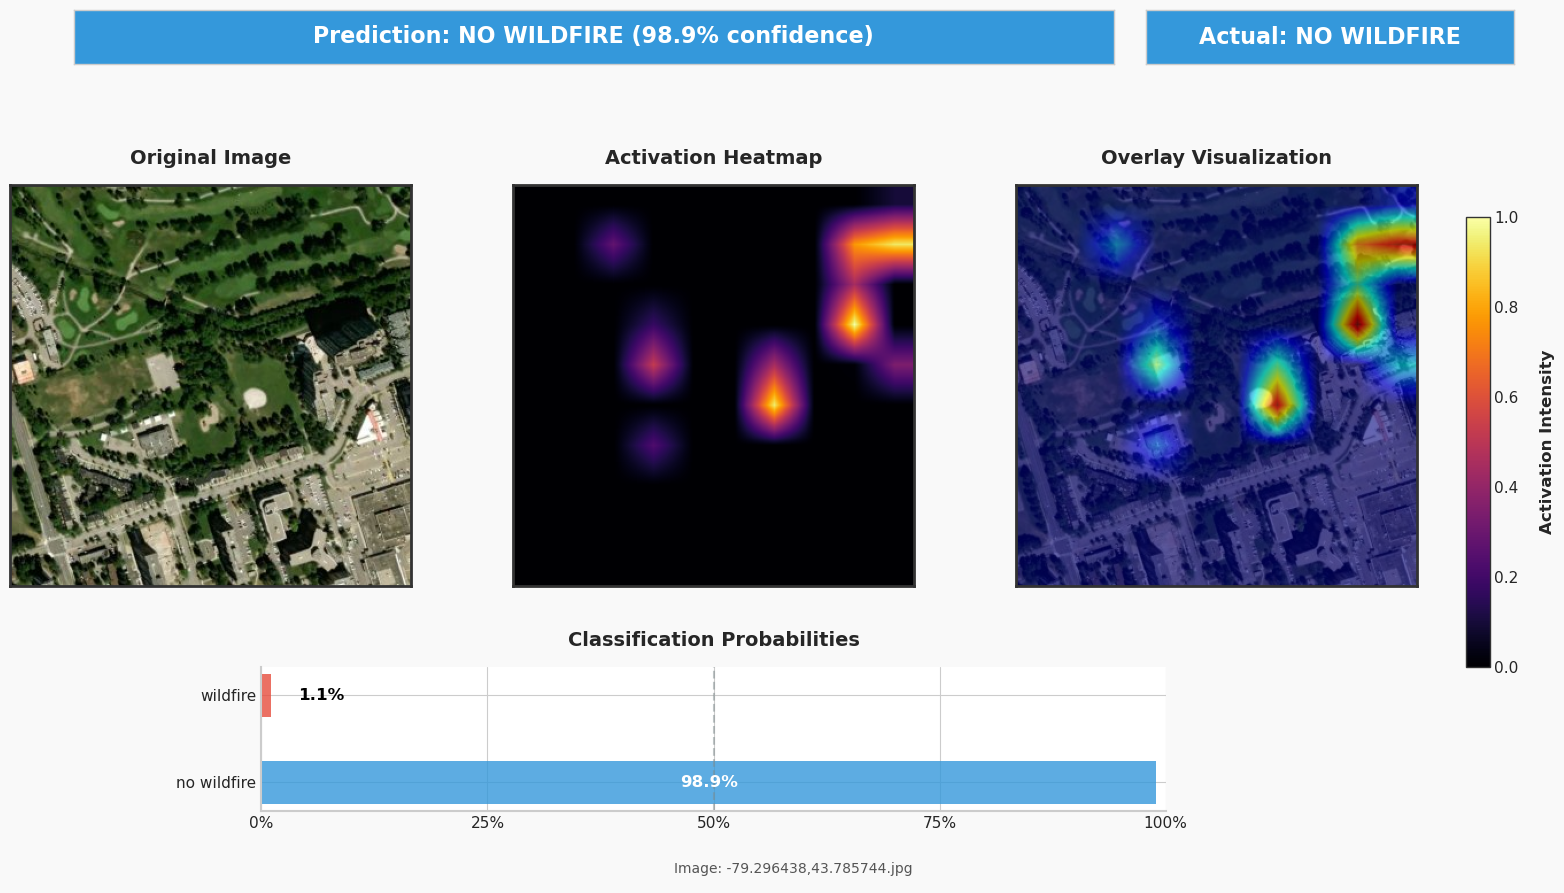

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Predictions for ./../data/test/wildfire/-78.96081,48.27878.jpg:
No Wildfire: 0.02%
Wildfire: 99.98%


/tmp/ipykernel_205309/4146192777.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fire_colors = plt.cm.get_cmap('inferno')
/tmp/ipykernel_205309/4146192777.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.9])


Visualization saved to ./../data/test/wildfire/-78.96081,48.27878_cam_viz.png


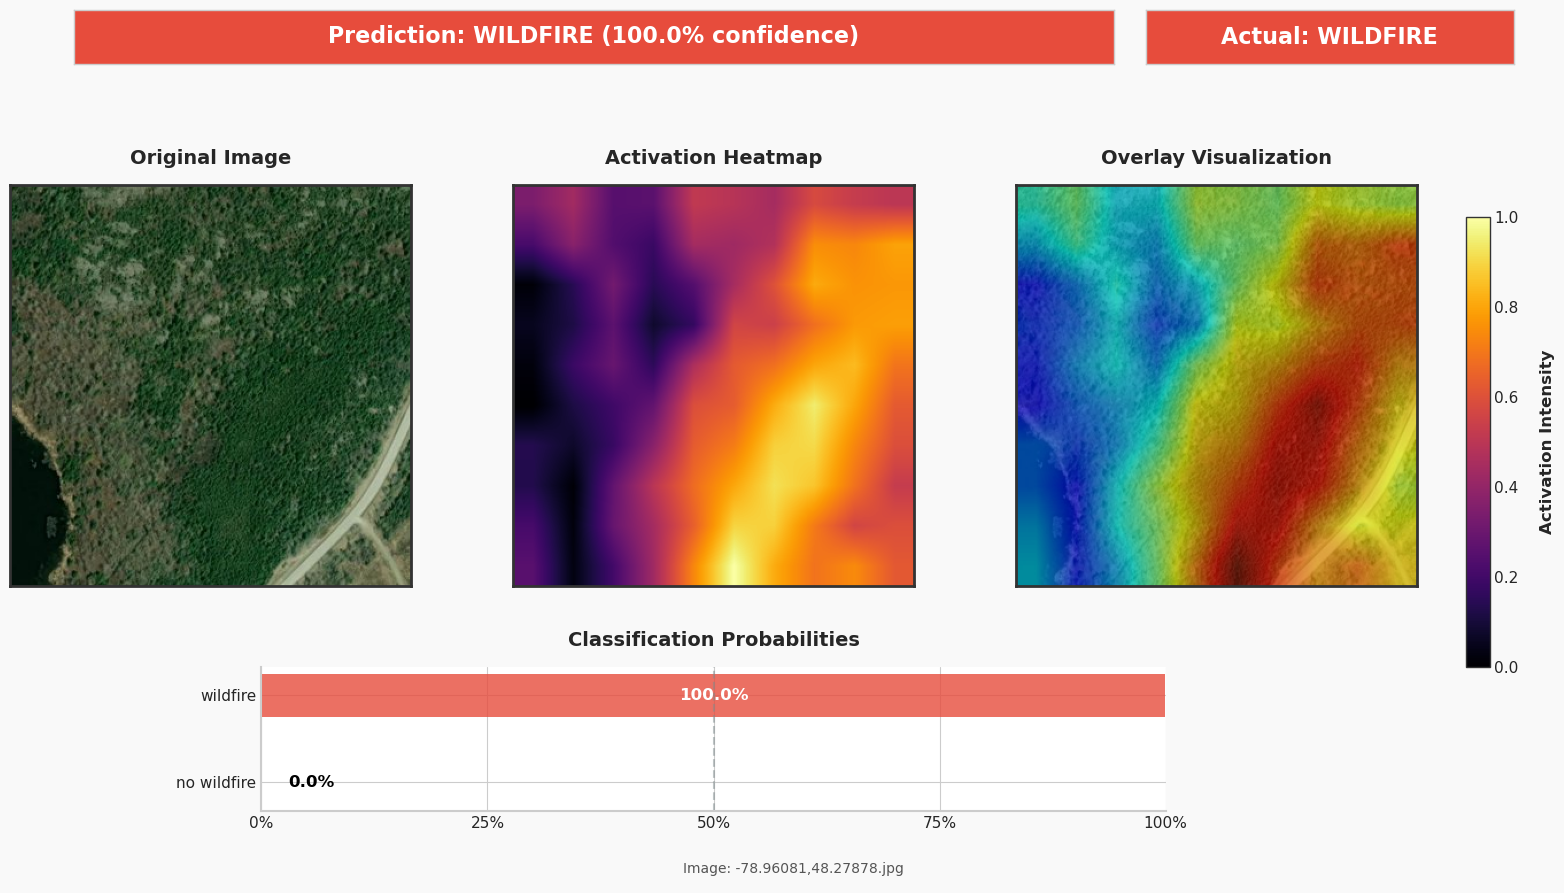

In [2]:
import os, random

num_examples = 5

dirs = ['./../data/test/wildfire', './../data/test/nowildfire']
all_images = [os.path.join(d, f) for d in dirs for f in os.listdir(d) if f.endswith('.jpg')]
random_images = random.sample(all_images, num_examples)

for img_path in random_images:
    # Define output path based on input filename
    output_filename = os.path.basename(img_path).replace('.jpg', '_cam_viz.png')
    output_path = os.path.join(os.path.dirname(img_path), output_filename)
    
    predict_and_visualize(img_path, output_path=output_path)